# Measures of Risk-Adjusted Returns
---
__Date Created:__ 2021-12-26  
__Author:__ Josh Mischung  
__email:__ josh@knoasis.io  

__Dataset:__ [`whale_navs.csv`](https://github.com/jmischung/Portfolio-Risk-Analysis/blob/main/Resources/whale_navs.csv)

__Comments on the Purpose & the Dataset:__  
The purpose of this notebook is to expand the exploration of risk-reward metrics used in the [`risk_return_analysis.ipynb`](https://github.com/jmischung/Portfolio-Risk-Analysis/blob/main/risk_return_analysis.ipynb) notebook. Along with the Sharpe Ratio, the Sortino, Calmar, Information, and M2 Ratios will be calculated to see what additional information they might provide for portfolio selection.

<br>

## Imports
---

In [1]:
# Import the required libraries and dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.style.use('ggplot')
%matplotlib inline

## Load Data  
---

In [2]:
# Import the data by reading in the CSV file and setting the DatetimeIndex 
# Review the first 5 rows of the DataFrame
fund_df = pd.read_csv(
    Path('Resources/whale_navs.csv'),
    index_col='date',
    parse_dates=True,
    infer_datetime_format=True
)
fund_df.columns = [name.lower().replace(' ', '_') for name in fund_df.columns]
fund_df.head()

,soros_fund_management_llc,paulson_&_co.inc.,tiger_global_management_llc,berkshire_hathaway_inc,s&p_500
date,,,,,
2014-10-01,31.950240,14.991826,59.977830,51.948712,194.35
2014-10-02,31.936110,14.994072,59.978626,51.957619,194.38
2014-10-03,31.969707,14.999596,60.002264,52.022484,196.52
2014-10-06,32.048215,14.999471,60.006244,52.036387,196.29
2014-10-07,31.964216,14.994720,59.993735,52.005864,193.26


## Sharpe Ratio  
---  
The Sharpe Ratio is a commonly used metric to assess the returns earned beyond the risk-free rate (which in recent history is often assumed to be zero.) per unit of risk, represented by annualized volatility. One drawback to the Sharpe Ratio is that it penalizes upside volatility (greater returns than normal) equally to downside volatility.

In [3]:
# Calculate daily returns.
daily_returns = fund_df.pct_change().dropna(axis=0, how='all').copy()

# Hold out the last year of returns to test
# selected portfolios againgst.
daily_returns_analyze = daily_returns[:-252]
daily_returns_holdout = daily_returns[-252:]

daily_returns_analyze.head()

,soros_fund_management_llc,paulson_&_co.inc.,tiger_global_management_llc,berkshire_hathaway_inc,s&p_500
date,,,,,
2014-10-02,-0.000442,0.000150,0.000013,0.000171,0.000154
2014-10-03,0.001052,0.000368,0.000394,0.001248,0.011009
2014-10-06,0.002456,-0.000008,0.000066,0.000267,-0.001170
2014-10-07,-0.002621,-0.000317,-0.000208,-0.000587,-0.015436
2014-10-08,0.000390,0.000369,0.000242,0.000842,0.017489


In [4]:
# Calculate the annual average return data for the for fund portfolios and the S&P 500
# Use 252 as the number of trading days in the year
# Review the annual average returns sorted from lowest to highest
avg_annl_rtn = (daily_returns_analyze.mean() * 252)

# Calculate the annualized Sharpe Ratios for each of the 4 portfolios and the S&P 500.
# Review the Sharpe ratios sorted lowest to highest

# Calculate the annualized standard deviaton.
std_dev_annl = (daily_returns_analyze.std() * np.sqrt(252))

# Calculate the Sharpe Ratio.
risk_ratios_df = pd.DataFrame(
    avg_annl_rtn / std_dev_annl,
    columns=['sharpe_ratio']
)
risk_ratios_df

,sharpe_ratio
soros_fund_management_llc,-0.218074
paulson_&_co.inc.,-0.095913
tiger_global_management_llc,0.564186
berkshire_hathaway_inc,0.528679
s&p_500,0.714305


## Sortino Ratio  
---  
As noted above, the Sharpe Ratio penalizes upside volatility the same as downside volatility. Other metrics have been developed in an attempt to determine the downside exposure of a portfolio concerning its returns without penalizing investors and traders that can deliver upside returns beyond the average.  

The Sortino Ratio achieves this by only considering days with negative returns when calculating the standard deviation. The effect is removing the penality to gains that might far exceed the mean returns.

In [5]:
# Calculate the annualized standard deviation
# for losses only.
neg_std_dev_annl = (daily_returns_analyze[daily_returns_analyze < 0].std() * np.sqrt(252))

# Calculate the Sortino ratio
risk_ratios_df['sortino_ratio'] = avg_annl_rtn / neg_std_dev_annl
risk_ratios_df

,sharpe_ratio,sortino_ratio
soros_fund_management_llc,-0.218074,-0.246034
paulson_&_co.inc.,-0.095913,-0.117876
tiger_global_management_llc,0.564186,0.666718
berkshire_hathaway_inc,0.528679,0.701791
s&p_500,0.714305,0.894260


## Information Ratio  
---  
The Information Ratio function is almost identical to the Sharpe Ratio, with the exception that it replaces the risk-free rate of return with the returns of a benchmark. The SPY index is often used as the benchmark.

In [6]:
# Calculate the Information Ratio
returns_difference = daily_returns_analyze.drop('s&p_500', axis=1).sub(
    daily_returns['s&p_500'],
    axis='index'
)
annl_volatility = returns_difference.std() * np.sqrt(252)
risk_ratios_df['information_ratio'] = (returns_difference.mean() * 252) / annl_volatility
risk_ratios_df

,sharpe_ratio,sortino_ratio,information_ratio
soros_fund_management_llc,-0.218074,-0.246034,-0.792278
paulson_&_co.inc.,-0.095913,-0.117876,-0.776491
tiger_global_management_llc,0.564186,0.666718,-0.698932
berkshire_hathaway_inc,0.528679,0.701791,-0.610553
s&p_500,0.714305,0.894260,NaN


## Modigliani Ratio (M2 Ratio)  
---  
The M2 Ratio is an adaptation of the Sharpe Ratio, calculated by multiplying the annualized standard deviation of a benchmark (again, often the SPY index) and multiplying it by the Sharpe Ratio. The risk-free rate is then added, but again in recent times, the risk-free rate of returns is often assumed to be zero.

In [7]:
# Calculate the Modigliani Ratio
benchmark_annl_volatility = daily_returns['s&p_500'].std() * np.sqrt(252)
risk_ratios_df['m2_ratio'] = risk_ratios_df.iloc[:-1, 0].mul(
    benchmark_annl_volatility,
    axis='index'
) + 0  # 0 represents the risk-free rate of return
risk_ratios_df

,sharpe_ratio,sortino_ratio,information_ratio,m2_ratio
soros_fund_management_llc,-0.218074,-0.246034,-0.792278,-0.039983
paulson_&_co.inc.,-0.095913,-0.117876,-0.776491,-0.017585
tiger_global_management_llc,0.564186,0.666718,-0.698932,0.103441
berkshire_hathaway_inc,0.528679,0.701791,-0.610553,0.096931
s&p_500,0.714305,0.894260,NaN,NaN


## Calmar Ratio  
---  
The Calmar Ratio is another one that seeks to assess returns per unit of risk without penalizing exceptional upside gains. What makes this ratio different is it replaces the standard deviation as the denominator with the max drawdown.

In [8]:
# Calculate the max drawdown for each portfolio.
cum_returns = (daily_returns_analyze + 1).cumprod()
peak = cum_returns.expanding(min_periods=1).max()
drawdown = ((cum_returns / peak) - 1).min()
drawdown

soros_fund_management_llc     -0.064800
paulson_&_co.inc.             -0.063287
tiger_global_management_llc   -0.017340
berkshire_hathaway_inc        -0.120894
s&p_500                       -0.201785
dtype: float64

In [9]:
# Calculate the Calmar Ratio
risk_ratios_df['calmar_ratio'] = avg_annl_rtn / abs(drawdown)
risk_ratios_df

,sharpe_ratio,sortino_ratio,information_ratio,m2_ratio,calmar_ratio
soros_fund_management_llc,-0.218074,-0.246034,-0.792278,-0.039983,-0.056719
paulson_&_co.inc.,-0.095913,-0.117876,-0.776491,-0.017585,-0.038183
tiger_global_management_llc,0.564186,0.666718,-0.698932,0.103441,0.274038
berkshire_hathaway_inc,0.528679,0.701791,-0.610553,0.096931,0.209938
s&p_500,0.714305,0.894260,NaN,NaN,0.486772


## Analysis  
---

In [13]:
# Calculate cumulative returns for the holdout period.
cum_returns_holdout = (daily_returns_holdout + 1).cumprod()
cum_returns_holdout.iloc[-1].sort_values()

paulson_&_co.inc.              0.970911
soros_fund_management_llc      1.003841
tiger_global_management_llc    1.030781
berkshire_hathaway_inc         1.097120
s&p_500                        1.108766
Name: 2020-09-11 00:00:00, dtype: float64

In [16]:
print("Mean of Risk-Reward Ratios for each Portfolio and the S&P 500\n")
display(risk_ratios_df.mean(axis=1))

Mean of Risk-Reward Ratios for each Portfolio and the S&P 500



soros_fund_management_llc     -0.270617
paulson_&_co.inc.             -0.209210
tiger_global_management_llc    0.181890
berkshire_hathaway_inc         0.185357
s&p_500                        0.698446
dtype: float64

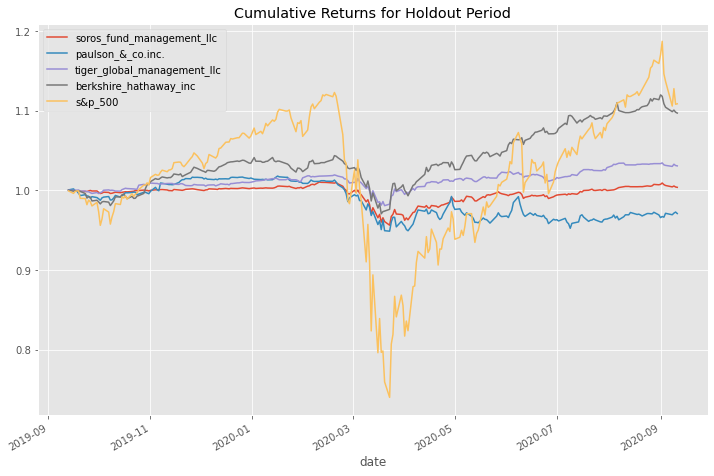

In [17]:
cum_returns_holdout.plot(
    figsize=(12, 8),
    title="Cumulative Returns for Holdout Period",
    legend=True
);

If any or all of the ratios that were calculated on the data from the analysis period had been used to select the fund portfolio or index most likely to offer the best returns per unit of assumed risk the top three assets would have been selected in their order of performance.  

The cumulative returns chart shows for the holdout period that the S&P 500 out-performed all of the fund portfolios, but did also suffer the largest drawdown. As long as panic selling didn't take place the SPY index was the best choice, but Berkshire Hathaway performed almost as well with a much smoother ride during a very tumulchuous time in the markets (March 2020).